In [81]:
%load_ext autoreload
%autoreload 2
from utils import *
from IPython.display import display, HTML
ins = BrainSpan()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
#DIR = "/Users/jiayao/Work/BrainDisorders/VIP_phenotype/Simons_VIP_Phase_2_Single_Gene_Dataset_v5.0"
DIR = "/Users/jiayao/Work/BrainDisorders/VIP_phenotype/Simons_Searchlight_Single_Gene_Dataset_v6.0"
VABS_DF, LGD_DF = LoadVIPSingleGeneData(DIR)
LGD_DF["HGVS"] = LGD_DF.apply(lambda row:addHGVS(row, Gene2Trans), axis=1)
LGD_DF.to_csv("data/SVIP.V6.Genes.HGVS.tsv", sep="\t", index=False)
#CleanUpSVIPVEPData()

In [83]:
Gene2Trans = LoadGenCodeTrans()
Transcripts = [x for x in Gene2Trans.values()]
SSC = LoadSSCCohort()

In [89]:
VABS_DF = AnnotateVEP2VABSDF(VABS_DF, LGD_DF, Gene2Trans, VEP)
VABS_DF.to_csv("data/svip.V6.recgenes.withlocation.csv", index=False)

In [90]:
VIP_VABS = pd.read_csv("data/svip.V6.recgenes.withlocation.csv")
sfari_id2vabs = {}
for sfari_id in VIP_VABS["sfari_id"].values:
    tmpdf = VIP_VABS[VIP_VABS["sfari_id"]==sfari_id]
    vabs = np.mean(tmpdf["composite_standard_score"].values)
    sfari_id2vabs[sfari_id] = vabs
print(VIP_VABS.shape)
VIP_VABS = VIP_VABS.drop_duplicates(subset="sfari_id", keep="first")
#VIP_VABS.head(2)
print(VIP_VABS.shape)
VIP_VABS["composite_standard_score"] = VIP_VABS.apply(lambda row:sfari_id2vabs[row["sfari_id"]], axis=1)
VIP_VABS["Cohort"] = "VIP"

(191, 6)
(135, 6)


In [91]:
VABS = pd.concat([SSC, VIP_VABS])
VABS = VABS[VABS["inheritance_status"]=="de-novo"]
#VABS = VABS.dropna()
VABS = VABS.reset_index(drop=True)

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [93]:
Genes = {}
hand = open("unifiedmodel/VIPgenes.gencode.v19.gtf", 'rt')
for l in hand:
    if l.startswith("#"):
        continue
    llist = l.strip().split("\t")
    info = gtf_info_parser(llist[8]) 
    CHR = llist[0].lstrip("chr")
    strand = llist[6]
    start = int(llist[3])
    end = int(llist[4])
    if llist[2] == "gene":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        Genes[gene_name] = GTFGene(gene_name, gene_id, strand)
    elif llist[2] == "transcript":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        transcript_name = info["transcript_id"]
        transcript_id = info["transcript_id"]
        transcript_type = info["transcript_type"]
        if transcript_id not in Genes[gene_name].Transcripts and transcript_type=="protein_coding" and transcript_id in selectedTrans:
            Genes[gene_name].Transcripts[transcript_id] = GTFTranscript(gene_name, transcript_name, transcript_id, strand)
    elif llist[2] == "exon":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        exon_id = info["exon_id"]
        transcript_name = info["transcript_id"]
        transcript_id = info["transcript_id"]
        transcript_type = info["transcript_type"]
        if transcript_type=="protein_coding" and transcript_id in selectedTrans:
            exon= GTFExon(exon_id, start, end, transcript_id, strand)
            #Genes[gene_name].Transcripts[transcript_id].Exons.append(exon)
            Genes[gene_name].Transcripts[transcript_id].Exons[exon_id] = exon
            

In [101]:
def searchExon(Gene, Location, Genes):
    Chr, interval = Location.split(":")
    Start, End = interval.split("-")
    Pos, LenV = int(Start), int(End)-int(Start)
    gene_obj = Genes[Gene]
    _Exons, Transcripts = [],[]
    #print(Location, Pos, LenV)
    islej = "F"
    for transid, transobj in gene_obj.Transcripts.items():
        if transid not in selectedTrans:
            continue
        transobj.SortExons()
        for exon in transobj.ExonSeq:
            if Pos > exon.start -3 and Pos < exon.end +3:
                _Exons.append(exon.ExonID)
                Transcripts.append(transid)
                break
            elif LenV > 0:
                if (Pos < exon.start-3 and Pos + LenV > exon.start ) or (Pos < exon.end and Pos + LenV > exon.end +3):
                    _Exons.append(exon.ExonID)
                    Transcripts.append(transid)
                    break
    for transid, transobj in gene_obj.Transcripts.items():
        if len(transobj.Exons) >= 2:
            interval1, interval2 = transobj.LastExonJunction()
            if Gene=="CHD2":
                print(interval1, interval2)
            if (Pos > interval1[0] and Pos < interval1[1]):
                islej = "T"
            elif (Pos > interval2[0] and Pos < interval2[1]):
                islej = "T"
    if len(list(set(_Exons))) == 0:
        return "NA", "NA", "NA"
    else:
        return list(set(_Exons))[0], list(set(Transcripts))[0], islej


VABS["Exons"] = ""
VABS["Transcripts"] = ""
#VABS = VABS[VABS["Cohort"]=="VIP"]
VABS = VABS[VABS["genetic_status"].isin(SVIPGenes)]
for i, row in VABS.iterrows():
    famid, gene, location = row["sfari_id"], row["genetic_status"], row["location"]
    ExonIDs, TranscriptIDs, islej = searchExon(gene, location, Genes)
    VABS.at[i, "Exons"] = ExonIDs
    VABS.at[i, "Transcripts"] = TranscriptIDs
    VABS.at[i, "isLEJ"] = islej
VABS = VABS.dropna()

(93567602, 93571237) (93563433, 93563488)
(93567602, 93571237) (93563433, 93563488)
(93567602, 93571237) (93563433, 93563488)
(93567602, 93571237) (93563433, 93563488)
(93567602, 93571237) (93563433, 93563488)


In [102]:
VABS2 = VABS[VABS["isLEJ"]=="T"]
VABS.head(2)

,Cohort,composite_standard_score,genetic_status,inheritance_status,location,sex,sfari_id,Exons,Transcripts,isLEJ
0,SSC,53.0,ADNP,de-novo,20:49509094-49509094,M,13545,ENSE00001455631.1,ENST00000396029.3,T
1,SSC,67.0,ADNP,de-novo,20:49510027-49510029,F,12130,ENSE00001455631.1,ENST00000396029.3,T


In [126]:
res = {}
#VABS2 = VABS[~VABS["sfari_id"].isin(["16159-x1", "16171-x1"])]
for gene in RecGenes:
    res[gene] = {}
    res[gene]["SameExon"] = []
    res[gene]["SameExonSameGender"] = []
    res[gene]["DiffExon"] = []
    #df = VABS2[VABS2["genetic_status"]==gene]
    df = VABS[VABS["genetic_status"]==gene]
    #df = VABS[(VABS["genetic_status"]==gene)&(VABS["isLEJ"]!="T")]
    for row1, row2 in itertools.combinations(df.iterrows(), r=2):
        row1,row2 = row1[1], row2[1]
        score1 = row1["composite_standard_score"]
        score2 = row2["composite_standard_score"]
        if row1["Exons"] == row2["Exons"]:
            if row1["isLEJ"] == "T" or row2["isLEJ"] == "T":
                continue
            res[gene]["SameExon"].append( abs(score1-score2) )
            if row1["sex"] == row2["sex"]:
                res[gene]["SameExonSameGender"].append( abs(score1-score2) )
        else:
            res[gene]["DiffExon"].append( abs(score1-score2) )

In [145]:
print(res["ASXL3"]["SameExonSameGender"])
print(res["ASXL3"]["SameExon"])

[5.0, 20.0, 12.0, 9.0, 14.0, 13.0, 34.0, 22.25, 18.0, 27.0, 25.0, 17.0, 14.0, 19.0, 18.0, 39.0, 27.25, 23.0, 32.0, 8.0, 11.0, 6.0, 7.0, 14.0, 2.25, 2.0, 7.0, 3.0, 2.0, 1.0, 22.0, 10.25, 6.0, 15.0, 5.0, 4.0, 25.0, 13.25, 9.0, 18.0, 1.0, 20.0, 8.25, 4.0, 13.0, 21.0, 9.25, 5.0, 14.0, 11.75, 16.0, 7.0, 4.25, 4.75, 9.0]
[5.0, 20.0, 12.0, 9.0, 14.0, 13.0, 34.0, 22.25, 18.0, 27.0, 25.0, 17.0, 14.0, 19.0, 18.0, 39.0, 27.25, 23.0, 32.0, 8.0, 11.0, 6.0, 7.0, 14.0, 2.25, 2.0, 7.0, 3.0, 2.0, 1.0, 22.0, 10.25, 6.0, 15.0, 5.0, 4.0, 25.0, 13.25, 9.0, 18.0, 1.0, 20.0, 8.25, 4.0, 13.0, 21.0, 9.25, 5.0, 14.0, 11.75, 16.0, 7.0, 4.25, 4.75, 9.0]


In [165]:
SameExonMeans, DiffExonMeans, SameExonSameGenderMeans, DiffExonMeans2 = [],[],[],[]
print("%20s\t%20s\t%s\t%s\t%s\t%s\t"%("SameExonVABSDiff", "NSameExonPair","SameExonSameGenderVABSDiff",
                                            "NSameExonSameGenderPair","SameGeneVABSDiff", "NSameGenePair"))
ExcludedGene = []
Mean1, Mean2 = [],[]
for gene in RecGenes:
    SameExon = res[gene]["SameExon"]
    SameExonSameGender = res[gene]["SameExonSameGender"]
    DiffExon = res[gene]["DiffExon"]
    if len(SameExon) == 0 or len(DiffExon) == 0:
        ExcludedGene.append(gene)
        continue
    SameExonMeans.append(np.mean(SameExon))
    DiffExonMeans.append(np.mean(DiffExon))
    if len(SameExonSameGender) != 0:
        SameExonSameGenderMeans.append(np.mean(SameExonSameGender))
        DiffExonMeans2.append(np.mean(DiffExon))
        Mean1.append(np.mean(SameExon))
        Mean2.append(np.mean(DiffExon))
    print("%s\t%.2f\t%d\t%.2f\t%d\t%.2f\t%d"%(gene, np.mean(SameExon), len(SameExon), np.mean(SameExonSameGender), 
                                    len(SameExonSameGender), np.mean(DiffExon), len(DiffExon)))

print(SameExonMeans, DiffExonMeans)
print(scipy.stats.wilcoxon(SameExonMeans, DiffExonMeans))
print(scipy.stats.wilcoxon(SameExonSameGenderMeans, DiffExonMeans2))
print(ExcludedGene)
print(np.mean(Mean1), np.mean(Mean2))

    SameExonVABSDiff	       NSameExonPair	SameExonSameGenderVABSDiff	NSameExonSameGenderPair	SameGeneVABSDiff	NSameGenePair	
ASXL3	13.23	55	13.23	55	15.49	165
CHD2	3.50	2	2.00	1	15.38	8
CHD8	11.00	1	nan	0	12.75	20
DSCAM	1.00	1	1.00	1	12.50	2
DYRK1A	12.83	6	14.00	3	17.32	22
FOXP1	7.78	3	1.17	1	10.24	7
HIVEP2	5.67	3	8.50	1	16.00	7
SCN2A	9.75	12	5.87	5	13.23	178
STXBP1	18.00	1	nan	0	12.89	9
SYNGAP1	2.33	1	2.33	1	13.85	35
[13.227272727272727, 3.5, 11.0, 1.0, 12.833333333333334, 7.777777777777781, 5.666666666666667, 9.75, 18.0, 2.3333333333333357] [15.488383838383841, 15.375, 12.75, 12.5, 17.318181818181817, 10.238095238095237, 16.0, 13.228464419475657, 12.88888888888889, 13.847619047619048]
WilcoxonResult(statistic=6.0, pvalue=0.02841686417486375)
WilcoxonResult(statistic=0.0, pvalue=0.011718685599768628)
['ADNP', 'CHAMP1', 'CSNK2A1', 'GRIN2B', 'HNRNPH2', 'MED13L', 'PACS1', 'PPP2R5D', 'SETBP1']
7.011047979797981 14.24946804521945


/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [ ]:
print(scipy.stats.mannwhitneyu(SameExon, SameGene))
ind = np.arange(4)  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=80)
rects = ax.bar(ind, Dat, width, yerr=Err,)

In [146]:
VABS[(VABS["genetic_status"]=="ASXL3")&(VABS["isLEJ"]=="F")]
#VABS[VABS["genetic_status"]=="STXBP1"]

,Cohort,composite_standard_score,genetic_status,inheritance_status,location,sex,sfari_id,Exons,Transcripts,isLEJ
66,VIP,37.00,ASXL3,de-novo,18:31319345-31319349,F,16159-x1,ENSE00003631966.1,ENST00000269197.5,F
67,VIP,32.00,ASXL3,de-novo,18:31318721-31318722,F,16171-x1,ENSE00003631966.1,ENST00000269197.5,F
68,VIP,57.00,ASXL3,de-novo,18:31318559-31318563,F,16179-x1,ENSE00003631966.1,ENST00000269197.5,F
70,VIP,49.00,ASXL3,de-novo,18:31318839-31318839,F,16188-x1,ENSE00003631966.1,ENST00000269197.5,F
72,VIP,46.00,ASXL3,de-novo,18:31319216-31319218,F,16207-x1,ENSE00003631966.1,ENST00000269197.5,F
73,VIP,51.00,ASXL3,de-novo,18:31318575-31318575,F,16221-x2,ENSE00003631966.1,ENST00000269197.5,F
77,VIP,50.00,ASXL3,de-novo,18:31319188-31319189,F,16248-x1,ENSE00003631966.1,ENST00000269197.5,F
81,VIP,71.00,ASXL3,de-novo,18:31318903-31318903,F,16745-x1,ENSE00003631966.1,ENST00000269197.5,F
82,VIP,59.25,ASXL3,de-novo,18:31319345-31319349,F,15215-x1,ENSE00003631966.1,ENST00000269197.5,F
83,VIP,55.00,ASXL3,de-novo,18:31318846-31318848,F,15234-x1,ENSE00003631966.1,ENST00000269197.5,F


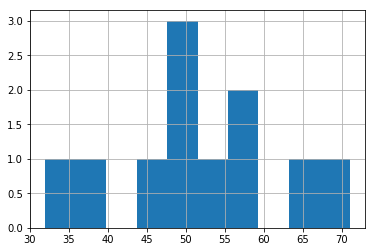

In [156]:
Gene = "ASXL3"
#Gene = "DYRK1A"
#Gene = "SCN2A"
VABS[(VABS["genetic_status"]==Gene)&(VABS["isLEJ"]=="F")]["composite_standard_score"].hist()

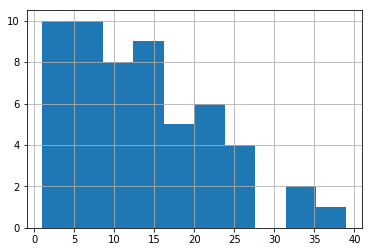

In [157]:
plt.hist(res[Gene]["SameExon"])
plt.grid(True)

In [106]:
DFF = VABS[VABS["isLEJ"]=="F"]

In [131]:
SameExon = []
SameExonSameGender = []
SameGene = []
ALLPairs = []
#Test = VABS[VABS["genetic_status"]!="ASXL3"]
Test = DFF[DFF["Cohort"]=="VIP"]
#Test = DFF[(DFF["Cohort"]=="VIP")&(DFF["genetic_status"]!="ASXL3")]
for row1, row2 in itertools.combinations(Test.iterrows(), r=2):
    row1,row2 = row1[1], row2[1]
    score1 = row1["composite_standard_score"]
    score2 = row2["composite_standard_score"]
    diff = abs(score1-score2)
    ALLPairs.append(diff)
    if row1["genetic_status"] == row2["genetic_status"]:
        SameGene.append(diff)
        if row1["Exons"] == row2["Exons"]:
            if row1["isLEJ"] == "T" or row2["isLEJ"] == "T":
                continue
            SameExon.append(diff)
            if row1["sex"] == row2["sex"]:
                SameExonSameGender.append(diff)

In [158]:
SameExon = []
SameExonSameGender = []
SameGene = []
ALLPairs = []
#Test = VABS[VABS["genetic_status"]!="ASXL3"]
#Test = DFF[DFF["Cohort"]=="VIP"]
Test = DFF[(DFF["Cohort"]=="VIP")&(DFF["genetic_status"]!="ASXL3")]
for row1, row2 in itertools.combinations(Test.iterrows(), r=2):
    row1,row2 = row1[1], row2[1]
    score1 = row1["composite_standard_score"]
    score2 = row2["composite_standard_score"]
    diff = abs(score1-score2)
    ALLPairs.append(diff)
    
    if row1["Exons"] == row2["Exons"]:
        if row1["isLEJ"] == "T" or row2["isLEJ"] == "T":
            continue
        SameExon.append(diff)
        if row1["sex"] == row2["sex"]:
            SameExonSameGender.append(diff)
    elif row1["genetic_status"] == row2["genetic_status"]:
        SameGene.append(diff)

In [159]:
Seq = [SameExonSameGender, SameExon, SameGene, ALLPairs]
Dat = [np.mean(x) for x in Seq]
Err = [np.std(x)/math.sqrt(len(x)) for x in Seq]

MannwhitneyuResult(statistic=2093.5, pvalue=0.001124496361039905)


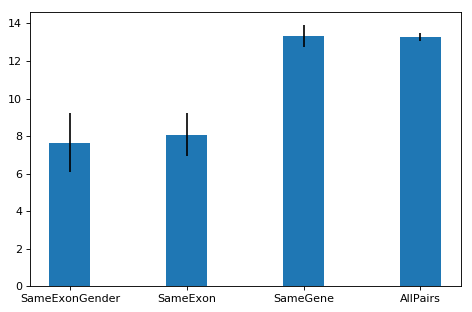

In [160]:
print(scipy.stats.mannwhitneyu(SameExon, SameGene))
ind = np.arange(4)  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=80)
rects = ax.bar(ind, Dat, width, yerr=Err,)
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(["SameExonGender", "SameExon", "SameGene", "AllPairs"])
fig.tight_layout()
plt.xticks(rotation=0)
plt.show()